In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import keras
from keras.utils import multi_gpu_model
import tensorflow as tf
from temnn.knet import net
from temnn.net.dataset import DataEntry,DataSet
from temnn.net.mods import local_normalize
from pyqstem.imaging import CTF
import matplotlib.pyplot as plt
# Peak detection
from stm.preprocess import normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
from collections import deque
import hyperspy.api as hs
import skimage.io
import skimage.color

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
graph_dir = 'graphs-graphene-hidose-paper'
graph_path = os.path.join(graph_dir, 'clusters-19.h5')

In [3]:
def load_CNN(graph_path, size, num_gpus=1):
    "Load the Keras neural net, and return a Model."
    kernel_num=32
    image_features=1
    num_classes=1

    if num_gpus == 1:
        x = keras.Input(shape=size+(image_features,))
        model = net.graph(x, output_features=num_classes)
        model.load_weights(graph_path)
    else:
        with tf.device('/cpu:0'):
            x = keras.Input(shape=size+(image_features,))
            model = net.graph(x, output_features=num_classes)
            model.load_weights(graph_path)
        model = multi_gpu_model(model, gpus=num_gpus)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return (x, model)

In [4]:
d = 'experiment/graphene/Serie_3_long/'
f = 'Graphenea-graphene_0162.dm3'
print(d+f)
a = hs.load(d+f)
image = a.data

# Crop the image
image = image[:,800:1024]
    
image_size = image.shape
print(image_size)
# Must be divisible by 8
image_size = tuple(np.array(image_size) // 8 * 8)
print(image_size)
image = image[:image_size[0],:image_size[1]]
print(image.shape, image.dtype)

experiment/graphene/Serie_3_long/Graphenea-graphene_0162.dm3
(2048, 224)
(2048, 224)
(2048, 224) int32


In [5]:
# Find the latest CNN
print("Looking for CNNs in files matching", graph_path)
gr = graph_path
print("Using CNN parameters in", gr)
x, model = load_CNN(gr, image_size, 1)

Looking for CNNs in files matching graphs-graphene-hidose-paper/clusters-19.h5
Using CNN parameters in graphs-graphene-hidose-paper/clusters-19.h5


In [6]:
rng = 12.0 / 0.12
img2 = local_normalize(image, rng, rng)

In [7]:
img2.shape, img2.max(), img2.min(), img2.std()

((2048, 224), 4.321866612318539, -3.9771663595026707, 0.981487098872238)

In [8]:
img2.shape = (1, ) + image_size + (1,)
predictions = model.predict(img2)

Find the peaks in the output from the CNN

In [9]:
peaks = find_local_peaks(predictions[0,:,:,0], min_distance=10, 
                         threshold=0.5, exclude_border=10,
                         exclude_adjacent=True)
peaks = refine_peaks(normalize(predictions[0,:,:,0]), peaks, 
                               disk(2), model='polynomial')

/Users/schiotz/development/structural-template-matching/build/lib.macosx-10.13-x86_64-3.6/stm/feature/fitting.py:56: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p, residues, rank, singval = np.linalg.lstsq(v.T, z)


In [10]:
# Cut more.  We want a thin slice for the presentation.
# The first 150 pixels or so in the x-direction are not good because the original image
# has almost no contrast in that part.

xmin = 148
ysize = 104
ymin = image.shape[1] // 4
ymax = ymin + ysize

image = image[xmin:,ymin:ymax]
img2 = img2[:,xmin:,ymin:ymax,:]
predictions = predictions[:,xmin:,ymin:ymax,:]
peaks_ok = np.logical_and(peaks[:,1] > ymin, peaks[:,1] < ymax)
peaks_ok = np.logical_and(peaks_ok, peaks[:,0] > xmin)
peaks = peaks[peaks_ok]
peaks[:,0] -= xmin
peaks[:,1] -= ymin

In [11]:
print(image.shape)

(1900, 104)


(-0.5, 1899.5, 111.20743482726104, -7.249217724253192)

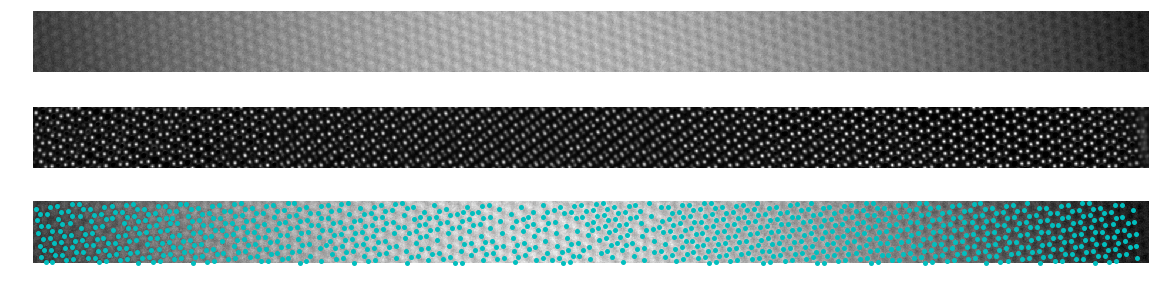

In [12]:
ig, (ax_raw, ax_pred, ax_atoms) = plt.subplots(3,1,figsize=(20,5))
im1 = ax_raw.imshow(image.T,cmap='gray', vmin=-3*image.std() + image.mean(), vmax=3*image.std() + image.mean())
#im1 = ax_raw.imshow(img2[0,:,:,0].T,cmap='gray', vmin=-4*img2.std(), vmax=4*img2.std())
im2 = ax_pred.imshow(predictions[0,:,:,0].T,cmap='gray')   
im3 = ax_atoms.imshow(image.T, cmap='gray')
ax_atoms.scatter(peaks[:,0], peaks[:,1], c='c', marker='.', linewidth=2.0)
ax_raw.axis('off')
ax_pred.axis('off')
ax_atoms.axis('off')

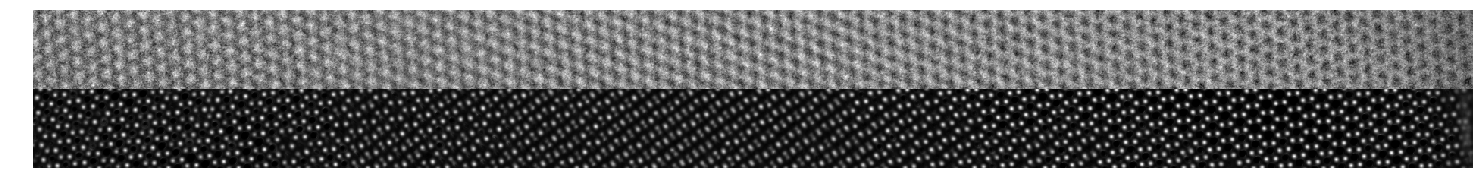

In [13]:
ysize = 20 * image.shape[1] / image.shape[0]
fig, (ax_raw, ax_pred) = plt.subplots(2,1,figsize=(20,2*ysize))
#im1 = ax_raw.imshow(image.T,cmap='gray', vmin=-3*image.std() + image.mean(), vmax=3*image.std() + image.mean())
im1 = ax_raw.imshow(img2[0,:,:,0].T,cmap='gray', vmin=-4*img2.std(), vmax=4*img2.std())
im2 = ax_pred.imshow(predictions[0,:,:,0].T,cmap='gray')   
#im3 = ax_atoms.imshow(image.T, cmap='gray')
#ax_atoms.scatter(peaks[:,0], peaks[:,1], c='c', marker='.', linewidth=2.0)
ax_raw.axis('off')
ax_pred.axis('off')
plt.tight_layout()
#fig.subplots_adjust(wspace=0)
fig.subplots_adjust(0,0,1,1,0,0)
#ax_atoms.axis('off')
fig.savefig('graphene_inversion.png')